# Fitting potential energy surfaces using neural networks

In this notebook we will go through the workflow of fitting a potential energy surface with a neural network. 

## The data pipeline

As you saw this morning in the digit classification example, the "pipeline" refers to the set of steps that need to be carried out to go from raw data to a fitted model.

### 1. The raw data

In this exercise, the raw data consists of a small data set where each sample is a different configuration of a methane and cyanide radical. For each configuration there is an energy that has been calculated at the couple cluster level of theory (highly accurate).

Therefore, the first step is to import the data from the two files `X.csv` and `Y.csv` file. The first one contains the configurations of the molecule and the second one the energies.

In [1]:
import sys
sys.path.append('.')
import pre_processing as pp
import numpy as np

In [2]:
# X = pp.loadX('X.csv')
# y = pp.loadY('Y.csv')
X, y = pp.loadData('/Users/walfits/Repositories/trainingNN/dataSets/PBE_B3LYP/pbe_b3lyp_partQ_rel.csv')

### 2. Pre-processing

The raw data has to be transformed from Cartesian coordinates to a molecular descriptor. This has to be suitable as a neural network input. Cartesian coordinates are not suitable because they are not *rotationally and translationally invariant*. Translational invariance simply means that if you shift a molecule around in space then the coordinates change. Similarly, if you rotate a whole molecule around, its Cartesian coordinates will change.

There are a variety of descriptors to choose from. Many of them are explained [here](http://aip.scitation.org/doi/full/10.1063/1.4966192). In this workshop, we will use the unsorted/unrandomised Coulomb matrix. The way the Coulomb matrix is constructed is explained [here](http://pubs.acs.org/doi/abs/10.1021/ct400195d). 

This version of the Coulomb matrix is not what you would use for a serious application of neural networks, because it does not satisfy permutational invariance. However, it is good enough for the purpose of this tutorial. 

In [3]:
descriptor = pp.CoulombMatrix(matrixX=X)
X_cm = descriptor.generateTriangCM()

print('X_cm has shape {}.'.format(str(X_cm.shape)))
print('y has shape {}.'.format(str(y.shape)))

X_cm has shape (17751, 28).
y has shape (17751,).


Each line of `X_cm` is a 'sample', i.e. a configuration of the system under study. There are in total 31 one configurations. The system has 7 atoms and the Coulomb matrix is a diagonal matrix of shape 7 by 7. But since it is diagonal, only the upper triangular part is needed. Hence the shape `(31, 28)`.

#### Scaling
Usually, after having extracted the features from the data, one can standardise them, so that every feature has a  standard deviation of 1 and mean of 0. This can be useful, because it means that the weights of the neural network can be in a similar range.

However, if the ratio of the features contains information, then scaling looses it. The diagonal elements of the Coulomb  matrix are always the same because they show the chemical identity of an atom. If this feature was scaled, all atoms would have a zero where their nuclear charge would have been, and therefore the chemical identity information would be lost.

Consequently, no scaling is done on the Coulomb matrix.

### 3. Hyper-parameters

In the neural network, there are many parameters that have to be chosen in order to obtain optimal performance. For example, there is the structure of the network (how many hidden layers, how many neurons in each layer), the regularisation parameter, the learning rate and the batch size in the mini-batch gradient descent... These are called 'hyper-parameters'. 

The hyper-parameter have to be optimised. This is usually done by trying different combinations of them and scoring the model. The hyper-parameters that give the best model are then kept. There are various techniques to do this, like manually choosing the different combinations of hyper parameters (highly tedious and inefficient), grid search, random search, Gaussian processes...

For the purpose of this tutorial, we will just do a grid search.

In [4]:
from sklearn import neural_network as nn
from sklearn import model_selection as modsel
from sklearn.pipeline import Pipeline


# Defining the model
neural_net = nn.MLPRegressor(max_iter=100000)

# Hyper-parameters to be optimised
hyper_param = {}

# Define the hidden_layer_sizes
HLS =[(40,20,10), (50, 30, 15), (60, 40, 20)]
hyper_param.update({'neural_net__hidden_layer_sizes':HLS})

# Define range of learning_init_rate
LRI = [0.001, 0.005, 0.01]
hyper_param.update({'neural_net__learning_rate_init':LRI})

# Alpha, the regularisation parameter
ALPHA = np.logspace(-3,-1,3)
hyper_param.update({'neural_net__alpha':ALPHA})

In the code above, we are choosing a regression neural network, with a [tanh](https://theclevermachine.wordpress.com/tag/tanh-function/) activation function in the hidden neurons. Then, a dictionary is created with a range of values for each hyper-parameter to be optimised. We are optimising the structure of the network, the learning rate and the regularisation parameter.

In the code below, a 'scikit learn pipeline' is constructed. However, in our simple exercise this pipeline contains only one step. The pipeline is optimised by trying all the combinations of the different hyper-parameters. K-fold cross-validation is used, which means that the network is trained on a subset of the data (here 2/3 of the data) and then tested on the remaining data (here 1/3 of the data). This process is repeated multiple times (here 3 times) and the part of the data used for training/testing is varied. The score is then the average of the 3 individual scores. 

In [5]:
# Doing k-fold cross-validation to choose hyper parameters
# cv_iter = modsel.KFold(n_splits=3)

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_cm, y, test_size=0.2, random_state=0)

# Generating the pipeline
pipe = Pipeline([('neural_net', neural_net)])

# Doing the gridsearch - i.e. trying all the combinations of parameters
grid_search = modsel.GridSearchCV(estimator=pipe, param_grid=hyper_param)
grid_search.fit(x_train, y_train)

print('Best accuracy: {:4.2f}'.format(grid_search.best_score_))
print('Best params: \n{}'.format(grid_search.best_params_))

Best accuracy: 0.45
Best params: 
{'neural_net__alpha': 0.10000000000000001, 'neural_net__learning_rate_init': 0.005, 'neural_net__hidden_layer_sizes': (40, 20, 10)}


The score is the r<sup>2</sup>. The closest to 1, the better. Once a satisfactory set of parameters have been found, we can update the model with them.

In [6]:
# Setting the best parameters
best_params = {}
best_params.update({'neural_net__hidden_layer_sizes':grid_search.best_params_['neural_net__hidden_layer_sizes']})

# Best initial learning rate
best_params.update({'neural_net__learning_rate_init': grid_search.best_params_['neural_net__learning_rate_init']})

# Best batch_size
best_params.update({'neural_net__alpha': grid_search.best_params_['neural_net__alpha']})

# Set best parameters
pipe.set_params(**best_params)

# Refit model with best hyper-parameters, ready for prediction
pipe.fit(x_train, y_train)

Pipeline(steps=[('neural_net', MLPRegressor(activation='relu', alpha=0.10000000000000001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(40, 20, 10), learning_rate='constant',
       learning_rate_init=0.005, max_iter=100000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))])

In [7]:
# Predictions
y_pred = pipe.predict(x_test)

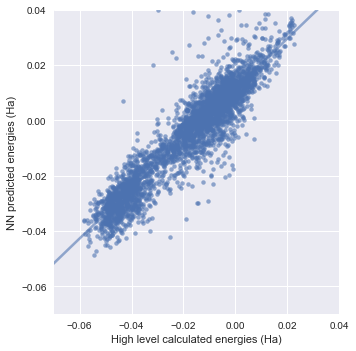

In [8]:
# Correlation plot
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame()
df['High level calculated energies (Ha)'] = y_test
df['NN predicted energies (Ha)'] = y_pred
lm = sns.lmplot('High level calculated energies (Ha)', 'NN predicted energies (Ha)', data=df,
                scatter_kws={"s": 20, "alpha": 0.6}, line_kws={"alpha": 0.5})
lm.set(ylim=[-0.07,0.04])
lm.set(xlim=[-0.07,0.04])

plt.show()